In [41]:
%load_ext autoreload
%autoreload 2
import torch
import pickle
from cot_probing.typing import *
from cot_probing.activations import (
    Activations,
    QuestionActivations,
    get_mean_activations_by_common_token,
)
from cot_probing.eval import EvalQuestion, get_common_tokens, get_correct_incorrect_idxs
from cot_probing.utils import get_train_test_split
from fancy_einsum import einsum

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
with open("../hf_results/activations_google--gemma-2-9b_snarks_S0_N151.pkl", "rb") as f:
    activations: Activations = pickle.load(f)
eval_results = activations.eval_results
eval_questions = eval_results.questions

In [43]:
FREQ_THRESHOLD = 1.0
TRAIN_FRAC = 0.8
SEED = 1
correct_q_idxs, incorrect_q_idxs = get_correct_incorrect_idxs(eval_questions)
train_correct_idxs, test_correct_idxs = get_train_test_split(
    correct_q_idxs, TRAIN_FRAC, SEED
)
train_incorrect_idxs, test_incorrect_idxs = get_train_test_split(
    incorrect_q_idxs, TRAIN_FRAC, SEED
)
common_tokens = get_common_tokens(eval_questions, FREQ_THRESHOLD)
mean_activations_correct = get_mean_activations_by_common_token(
    common_tokens, activations, train_correct_idxs
)
mean_activations_incorrect = get_mean_activations_by_common_token(
    common_tokens, activations, train_incorrect_idxs
)

In [44]:
probes_by_token = {
    t: mean_activations_correct[t] - mean_activations_incorrect[t]
    for t in common_tokens
}

In [45]:
probe = probes_by_token[common_tokens[0]].clone() / len(common_tokens)
for t in common_tokens[1:]:
    probe += probes_by_token[t] / len(common_tokens)

## Get probe activations

In [46]:
def get_probe_acts() -> list[Float[torch.Tensor, " layers locs"]]:
    probe_acts = []
    for q_activation in activations.activations_by_question:
        probe_acts.append(
            einsum(
                "layers locs model, layers model -> layers locs",
                q_activation.activations,
                probe,
            )
        )
    return probe_acts


all_probe_acts = get_probe_acts()
n_layers = all_probe_acts[0].shape[0]
min_max_probe_acts = []
for layer in range(n_layers):
    min_probe_act = min(
        [probe_acts[layer].min().item() for probe_acts in all_probe_acts]
    )
    max_probe_act = max(
        [probe_acts[layer].max().item() for probe_acts in all_probe_acts]
    )
    print(f"Layer {layer}: min={min_probe_act:.2f}, max={max_probe_act:.2f}")
    min_max_probe_acts.append((min_probe_act, max_probe_act))

Layer 0: min=-5.33, max=9.42
Layer 1: min=-4.73, max=14.27
Layer 2: min=-4.79, max=19.80
Layer 3: min=-10.50, max=18.42
Layer 4: min=-9.63, max=22.82
Layer 5: min=-20.22, max=25.39
Layer 6: min=-29.97, max=36.48
Layer 7: min=-25.14, max=57.69
Layer 8: min=-30.22, max=75.17
Layer 9: min=-28.89, max=103.18
Layer 10: min=-32.79, max=117.94
Layer 11: min=-48.82, max=131.41
Layer 12: min=-69.96, max=141.53
Layer 13: min=-157.96, max=145.74
Layer 14: min=-94.50, max=220.09
Layer 15: min=-377.76, max=186.30
Layer 16: min=-588.63, max=297.67
Layer 17: min=-484.17, max=404.90
Layer 18: min=-1191.41, max=476.08
Layer 19: min=-186.53, max=758.39
Layer 20: min=-184.14, max=1173.54
Layer 21: min=-373.86, max=863.38
Layer 22: min=-411.69, max=725.00
Layer 23: min=-2749.43, max=640.32
Layer 24: min=-3745.92, max=442.30
Layer 25: min=-5177.23, max=465.58
Layer 26: min=-497.24, max=1629.23
Layer 27: min=-810.38, max=1318.24
Layer 28: min=-5407.19, max=1039.42
Layer 29: min=-778.86, max=2469.35
Layer 30

## Prompt visualizations

In [47]:
from cot_probing.vis import visualize_tokens_html
from IPython.display import HTML
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
text = "###\n\nWhat is going oooonnn???\nIdk."
tokens = tokenizer.encode(text)
display(
    HTML(
        visualize_tokens_html(
            tokens,
            tokenizer,
            [random.random() for _ in tokens],
            vmin=0.0,
            vmax=1.0,
        )
    )
)

In [48]:
def vis_q_layer(q_idx: int, layer: int):
    probe_acts = all_probe_acts[q_idx][layer]
    print(f"Layer {layer}")
    first_response_loc = eval_questions[q_idx].locs["response"][0]
    tokens = eval_results.questions[q_idx].tokens[first_response_loc:]
    values = probe_acts.tolist()
    vmin, vmax = min_max_probe_acts[layer]
    display(
        HTML(visualize_tokens_html(tokens, tokenizer, values, vmin=vmin, vmax=vmax))
    )


def vis_q_layers(q_idx: int, layers: list[int]):
    print(f"Question {q_idx}")
    first_response_loc = eval_questions[q_idx].locs["response"][0]
    context_tokens = eval_results.questions[q_idx].tokens[
        first_response_loc - 100 : first_response_loc
    ]
    display(HTML(visualize_tokens_html(context_tokens, tokenizer)))
    for layer in layers:
        vis_q_layer(q_idx, layer)

In [49]:
vis_q_layers(test_correct_idxs[3], [0, 20, 30, 40])

Question 20


Layer 0


Layer 20


Layer 30


Layer 40


In [50]:
vis_q_layers(test_incorrect_idxs[3], [0, 20, 30, 40])

Question 72


Layer 0


Layer 20


Layer 30


Layer 40


## Histograms

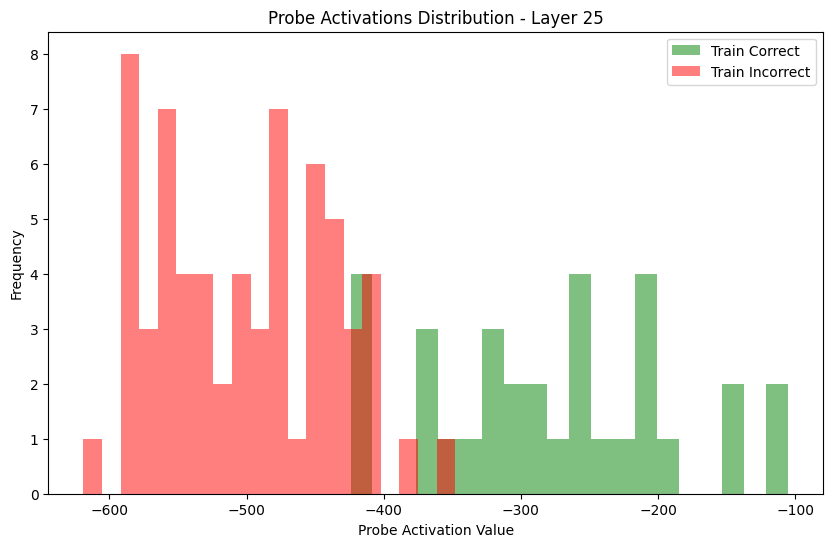

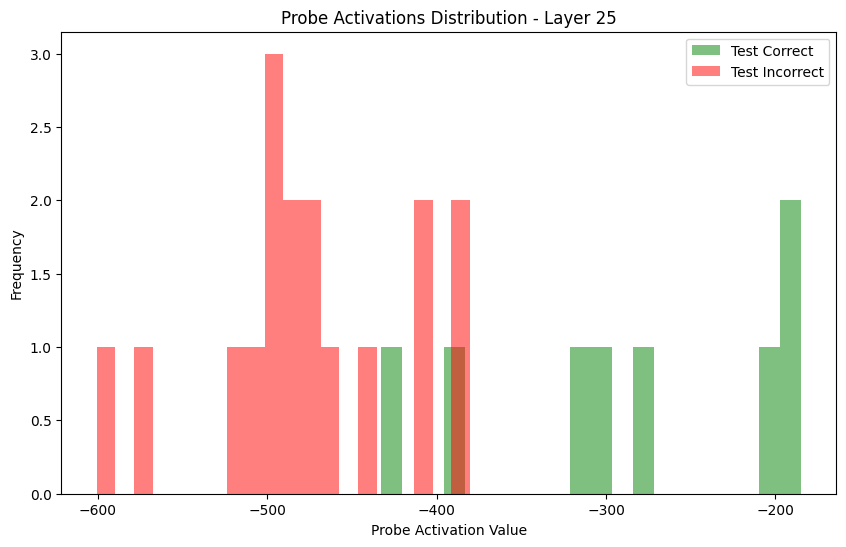

In [56]:
import matplotlib.pyplot as plt

layer = 25
mean_probe_act = [probe_act[layer].mean().item() for probe_act in all_probe_acts]
train_mean_correct_probe_act = [mean_probe_act[i] for i in train_correct_idxs]
train_mean_incorrect_probe_act = [mean_probe_act[i] for i in train_incorrect_idxs]
test_mean_correct_probe_act = [mean_probe_act[i] for i in test_correct_idxs]
test_mean_incorrect_probe_act = [mean_probe_act[i] for i in test_incorrect_idxs]
plt.figure(figsize=(10, 6))
plt.hist(
    train_mean_correct_probe_act,
    bins=20,
    alpha=0.5,
    color="green",
    label="Train Correct",
)
plt.hist(
    train_mean_incorrect_probe_act,
    bins=20,
    alpha=0.5,
    color="red",
    label="Train Incorrect",
)
plt.title(f"Probe Activations Distribution - Layer {layer}")
plt.xlabel("Probe Activation Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(
    test_mean_correct_probe_act, bins=20, alpha=0.5, color="green", label="Test Correct"
)
plt.hist(
    test_mean_incorrect_probe_act,
    bins=20,
    alpha=0.5,
    color="red",
    label="Test Incorrect",
)
plt.title(f"Probe Activations Distribution - Layer {layer}")
plt.xlabel("Probe Activation Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()